<h1 style="color:blue">Data Science WiSe 2018/19 - Prof. Dr. M. Tropmann-Frick</h1>
<hr>
<h2 style="text-decoration:underline"><center>Übungsblatt 3</center></h2>

## Overview 
Citi Bike is the nation's largest bike share program, with 12,000 bikes and 750 stations across Manhattan, Brooklyn, Queens and Jersey City. It was designed for quick trips with convenience in mind, and it’s a fun and affordable way to get around town.

Citi Bike publishes their monthly trip data, which can be used for analysis, development and visualization. We are going to perform an exploratory data analysis on a data set from January 2017. 

The data includes:
- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth

Some interesting questions that we will set out to answer:
1. What are the most popular stations in general? During daytime, during nighttime?
2. How long is an average trip duration by user types? 
3. What are the most popular trips? 
4. Which bike is the busiest? By number of times used? By minutes used? 
5. How is the performance of users by age and gender based on average speed and distance?

## Explore the data
Let's check if there is any noise and how much data is missing. We will deal them along the way before creating a chart.
1. Any missing data? 
 - A small portion of birthyears and user types is missing. 
2. Any Noise? 
 - The birthyears of some users are just impossible. This could be the result of wrong input.    
3. Format the data correctly to prevent errors in visualisation:
 - TripDuration - int
 - Start Time - datetime
 - Stop Time - datetime 
 - Start Station ID - category
 - Start Station Name - category
 - Start Station Latitude - float
 - Start Station Longitude - float
 - End Station ID - category
 - End Station Name - category
 - End Station Latitude - float              
 - End Station Longitude - float             
 - Bike ID - category 
 - User Type - category
 - Birth Year - int
 - Gender - category

In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
    color: black !important;
}

In [2]:
# load libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import datetime as dt

In [3]:
# load data 
df = pd.read_csv('201701-citibike-tripdata.csv')

In [4]:
# explore the data
# len(df)
# df.info()
# df.describe(include = 'all')
# df.dtypes

In [5]:
# check for percentage of missing data
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys = ['Total', 'Percent'])
    return missing_data
missing_data(df)

,Total,Percent
Birth Year,29076,4.168005
User Type,3193,0.441337
Gender,0,0.000000
Bike ID,0,0.000000
End Station Longitude,0,0.000000
End Station Latitude,0,0.000000
End Station Name,0,0.000000
End Station ID,0,0.000000
Start Station Longitude,0,0.000000
Start Station Latitude,0,0.000000


In [6]:
# format the data correctly 
df.columns = ['TripDuration', 'StartTime', 'StopTime', 'StartStationID',
       'StartStationName', 'StartStationLatitude',
       'StartStationLongitude', 'EndStationID', 'EndStationName',
       'EndStationLatitude', 'EndStationLongitude', 'BikeID', 'UserType',
       'BirthYear', 'Gender']
df.StartTime = to_datetime(df.StartTime)
df.StopTime = to_datetime(df.StopTime)
df.StartStationID = df.StartStationID.astype('category')
df.StartStationName = df.StartStationName.astype('category')
df.EndStationID = df.EndStationID.astype('category')
df.EndStationName = df.EndStationName.astype('category')
df.BikeID = df.BikeID.astype('category')
df.Gender = df.Gender.astype('category')
df.UserType = df.UserType.astype('category')
round(df.describe(), 2)

,TripDuration,StartStationLatitude,StartStationLongitude,EndStationLatitude,EndStationLongitude,BirthYear
count,726676.00,726676.00,726676.00,726676.00,726676.00,697600.00
mean,777.90,40.74,-73.98,40.74,-73.99,1977.12
std,11246.83,0.07,0.12,0.07,0.12,11.93
min,61.00,0.00,-74.03,0.00,-74.03,1885.00
25%,331.00,40.72,-74.00,40.72,-74.00,1969.00
50%,526.00,40.74,-73.99,40.74,-73.99,1979.00
75%,860.00,40.76,-73.98,40.76,-73.98,1987.00
max,5325688.00,40.80,0.00,40.80,0.00,2000.00


## Q1: What are the most popular stations in general? During daytime, during nighttime?

As stated on the Citibike NYC website, the data has already been processed to remove any trips that were below 60 seconds because they are potentially false starts. However, I also considered a trip that lasts less than 1.5 minutes and has the same start and end station to be false start. This happens when users try to re-dock a bike to ensure it's secure. 

For the visualisation, I will get the top 10 most used stations in general. And also 5 most popular stations during daytime and nighttime respectively. 

In [7]:
# check for false starts 
df[df.TripDuration < 90].head()[['StartStationName','EndStationName']]

,StartStationName,EndStationName
59,5 Ave & E 73 St,5 Ave & E 73 St
296,St Marks Pl & 2 Ave,St Marks Pl & 1 Ave
338,Canal St & Rutgers St,Pike St & E Broadway
857,Monroe St & Bedford Ave,Monroe St & Bedford Ave
955,Plaza St West & Flatbush Ave,7 Ave & Park Pl


In [8]:
# drop false starts 
df = df.drop(df[(df.TripDuration < 90) & (df.StartStationID.astype(int) == df.EndStationID).astype(int)].index)

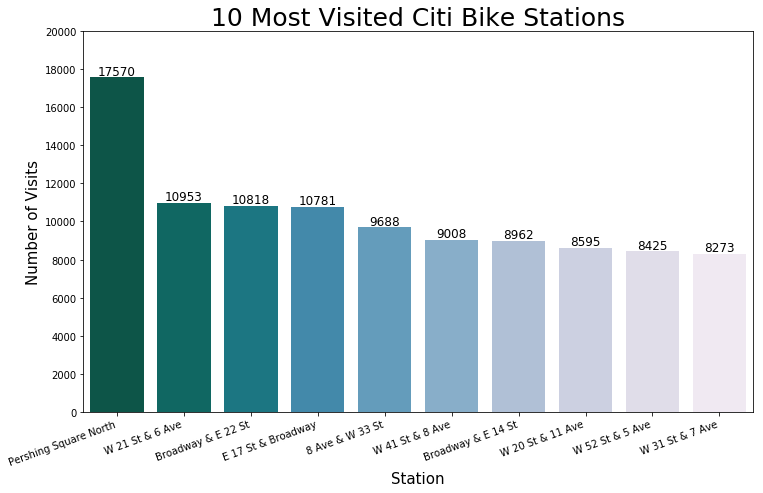

In [9]:
# get 10 most visited stations
top10 = pd.DataFrame()
count_stations = pd.concat([df.StartStationName, df.EndStationName], axis = 0).value_counts()
top10['Station'] = count_stations.head(10).index
top10['Visits'] = count_stations.head(10).values

# plot 10 most visited stations
ax = plt.subplots(figsize = (12, 7))
ax = sns.barplot(top10.Station, top10.Visits, palette = 'PuBuGn_r')
ax.set_title('10 Most Visited Citi Bike Stations', fontsize = 25)
ax.set_xlabel("Station", fontsize = 15)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 20, ha = 'right')
ax.set_ylabel("Number of Visits", fontsize = 15)
ax.yaxis.set_ticks(np.arange(0, 20001, 2000))
ax.set_axisbelow(True)
for index, row in top10.iterrows():
    ax.text(index,row.Visits + 150, row.Visits, 
            color='black', ha = "center", fontsize = 12)
plt.show()

In [24]:
# get data for 5 most visited stations during daytime
start_stations_day = df[(df.StartTime.dt.hour >= 6) & (df.StartTime.dt.hour < 18)].StartStationName
end_stations_day = df[(df.StopTime.dt.hour >= 6) & (df.StopTime.dt.hour < 18)].EndStationName
count_stations_day = pd.concat([start_stations_day, end_stations_day], axis = 0).value_counts()
top5_day = pd.DataFrame()
top5_day['Station'] = count_stations_day.head(5).index
top5_day['Visits'] = count_stations_day.head(5).values

In [25]:
# get data for 5 most visited stations during nighttime
start_stations_night = df[(df.StartTime.dt.hour < 6) | (df.StartTime.dt.hour >= 18)].StartStationName
end_stations_night = df[(df.StopTime.dt.hour < 6) | (df.StopTime.dt.hour >= 18)].EndStationName
count_stations_night = pd.concat([start_stations_night, end_stations_night], axis = 0).value_counts()
top5_night = pd.DataFrame()
top5_night['Station'] = count_stations_night.head(5).index
top5_night['Visits'] = count_stations_night.head(5).values

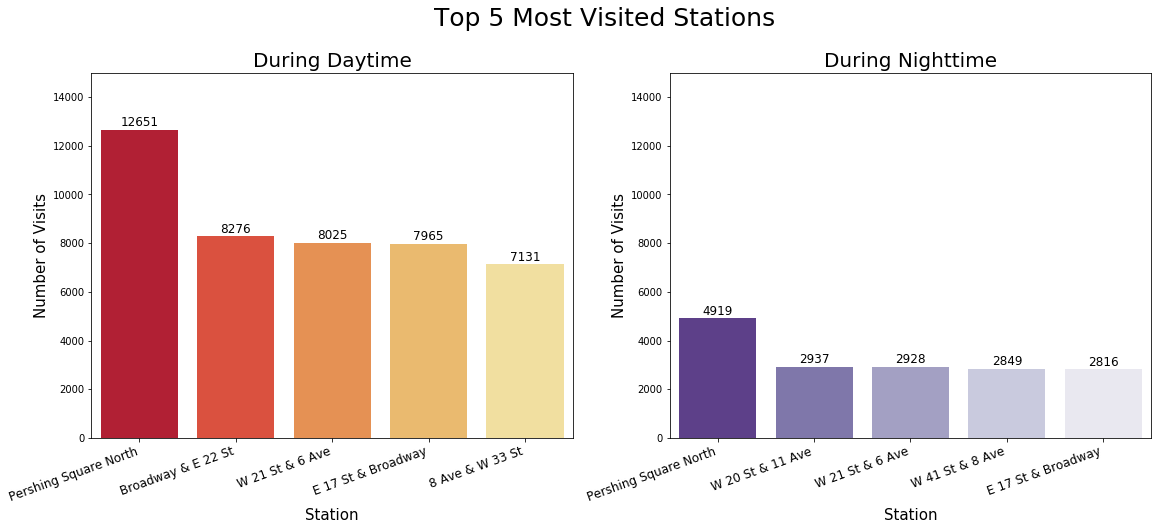

In [26]:
f, axes = plt.subplots(1, 2, figsize = (19, 7))
f.suptitle('Top 5 Most Visited Stations', size = 25)
f.subplots_adjust(top = 0.85)

# plot 5 most visited stations during daytime
ax1 = sns.barplot(top5_day.Station, top5_day.Visits, ax = axes[0], palette = 'YlOrRd_r')
ax1.set_title('During Daytime', fontsize = 20)
ax1.set_xlabel("Station", size = 15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 20, ha = 'right', size = 12)
ax1.set_ylabel("Number of Visits", fontsize = 15)
ax1.set(ylim = (0, 15000))
for index, row in top5_day.iterrows():
    ax1.text(index,row.Visits + 150, row.Visits, 
            color='black', ha = "center", fontsize = 12)

# plot 5 most visited stations during nighttime
ax2 = sns.barplot(top5_night.Station, top5_night.Visits, ax = axes[1], palette = 'Purples_r')
ax2.set_title('During Nighttime', fontsize = 20)
ax2.set_xlabel("Station", size = 15)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 20, ha = 'right', size = 12)
ax2.set_ylabel("Number of Visits", size = 15)
ax2.set(ylim = (0, 15000))
for index, row in top5_night.iterrows():
    ax2.text(index,row.Visits + 150, row.Visits, 
            color='black', ha = "center", size = 12)
plt.show()

## Q2: How long is an average trip duration by each user type?
As missing user type accounts for only 0.44% of the data, we can safely remove them. 

There are anomalies in trip duration. As seen in the violin graph, some trip duration is so enormous that it will affect our visualisation and result greatly. According to the Citibike NYC website, no matter what kind of pass do you buy, riding more than 2 hours will cost you a fortune due to additional charge. Therefore, any trips that took more than 2 hours will be removed, as they are likely malfunctioned or the bikes were stolen.

I will place 2 graphs, one with anomalies and one without, side by side to see the effect of removing 2-hour-trip. 

In [42]:
# add minutes column for trip duration 
df['Minutes'] = round(df.TripDuration / 60).astype(int) 

# copy of the original data frame 
df1 = df.copy()

# drop rows where User Type is not given
df = df.dropna(subset = ['UserType'])

# remove any trip that lasts more than 2 hours 
df = df.drop(df[df.Minutes > 120].index)

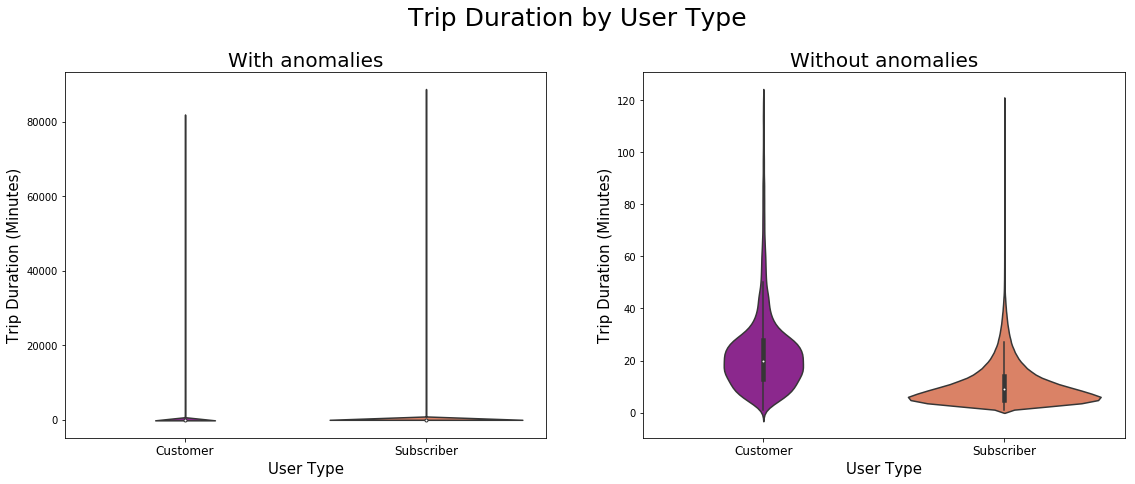

In [44]:
# use boxplot to visualise data distribution 
f, axes = plt.subplots(1, 2, figsize = (19, 7))
f.suptitle('Trip Duration by User Type', size = 25)
f.subplots_adjust(top = 0.85)

# plot trip duration with anomalies
ax1 = sns.violinplot(x = 'UserType', y = 'Minutes', data = df1, ax = axes[0], palette = 'plasma')
ax1.set_title('With anomalies', size = 20)
ax1.set_xlabel('User Type', size = 15)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 12)
ax1.set_ylabel('Trip Duration (Minutes)', size = 15)

# plot trip duration without anomalies
ax2 = sns.violinplot(x = 'UserType', y = 'Minutes', data = df, ax = axes[1], palette = 'plasma')
ax2.set_title('Without anomalies', size = 20)
ax2.set_xlabel('User Type', size = 15)
ax2.set_xticklabels(ax2.get_xticklabels(), size = 12)
ax2.set_ylabel('Trip Duration (Minutes)', size = 15)
plt.show()

In [36]:
# calculate average trip duration with anomalies
td_user = pd.DataFrame()
td_user['AvgTripDuration'] = round(df1.groupby('UserType').Minutes.mean(), 2)
td_user = td_user.reset_index()
td_user['UserType'] = td_user.UserType.astype('object')
td_user

,UserType,AvgTripDuration
0,Customer,23.17
1,Subscriber,10.88


In [37]:
# calculate average trip duration without anomalies
td_user2 = pd.DataFrame()
td_user2['AvgTripDuration'] = round(df.groupby('UserType').Minutes.mean(), 2)
td_user2 = td_user2.reset_index()
td_user2['UserType'] = td_user.UserType.astype('object')
td_user2

,UserType,AvgTripDuration
0,Customer,23.17
1,Subscriber,10.88


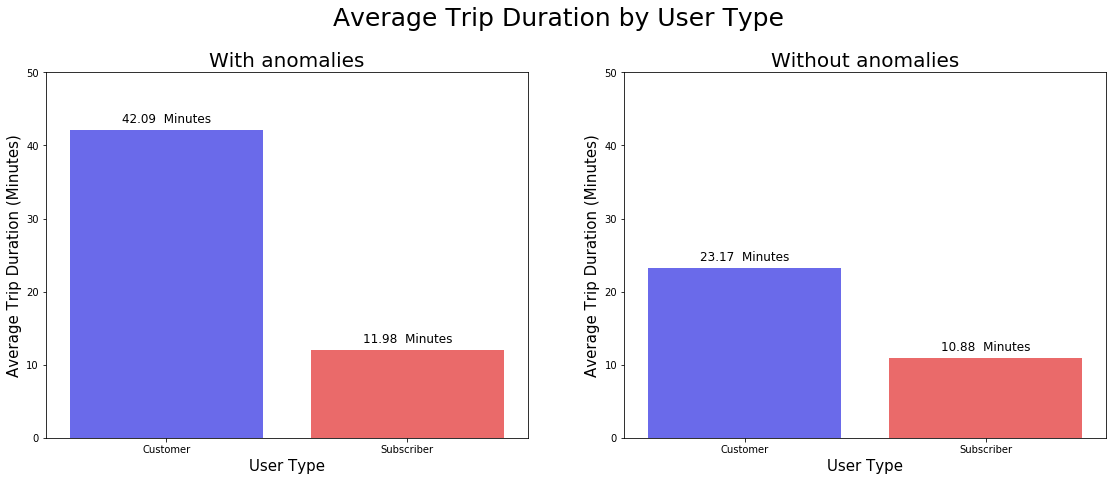

In [33]:
f, axes = plt.subplots(1, 2, figsize = (19, 7))
f.suptitle('Average Trip Duration by User Type', size = 25)
f.subplots_adjust(top = 0.85)

# plot average trip duration with anomalies
ax1 = sns.barplot('UserType', 'AvgTripDuration', data = td_user, ax = axes[0], palette = 'seismic')
ax1.set_title('With anomalies', size = 20)
ax1.set_xlabel('User Type', size = 15)
ax1.set_ylabel('Average Trip Duration (Minutes)', size = 15)
ax1.set(ylim = (0, 50))
for index, row in td_user.iterrows():
    ax1.text(index,row.AvgTripDuration + 1,(str(row.AvgTripDuration) + "  Minutes"), 
             color='black', ha="center", fontsize = 12)

# plot average trip duration without anomalies 
ax2 = sns.barplot('UserType', 'AvgTripDuration', data = td_user2, palette = 'seismic')
ax2.set_title('Without anomalies', size = 20)
ax2.set_xlabel('User Type', size = 15)
ax2.set_ylabel('Average Trip Duration (Minutes)', size = 15)
ax2.set(ylim = (0, 50))
for index, row in td_user2.iterrows():
    ax2.text(index,row.AvgTripDuration + 1,(str(row.AvgTripDuration)+"  Minutes"), 
             color='black', ha="center", fontsize = 12)    
    
# plot average trip duration without anomalies
plt.show()

## Q3: What are the most popular trips?
To find the most popular trips, we will use groupby on the start station name and the end station name as they together creates a trip between 2 stations. 

In [45]:
# find most popular trips
trips_df = pd.DataFrame()
trips_df['NumberOfTrips'] = df.groupby(['StartStationName', 'EndStationName']).size()
trips_df = trips_df.reset_index()
trips_df = trips_df.sort_values('NumberOfTrips', ascending = False)
trips_df.StartStationName = trips_df.StartStationName.astype(str)
trips_df.EndStationName = trips_df.EndStationName.astype(str)
trips_df['Trip'] = trips_df.StartStationName + ' to ' + trips_df.EndStationName
trips_df = trips_df.head(10)
trips_df = trips_df.drop(['StartStationName', "EndStationName"], axis = 1)
trips_df = trips_df.reset_index()

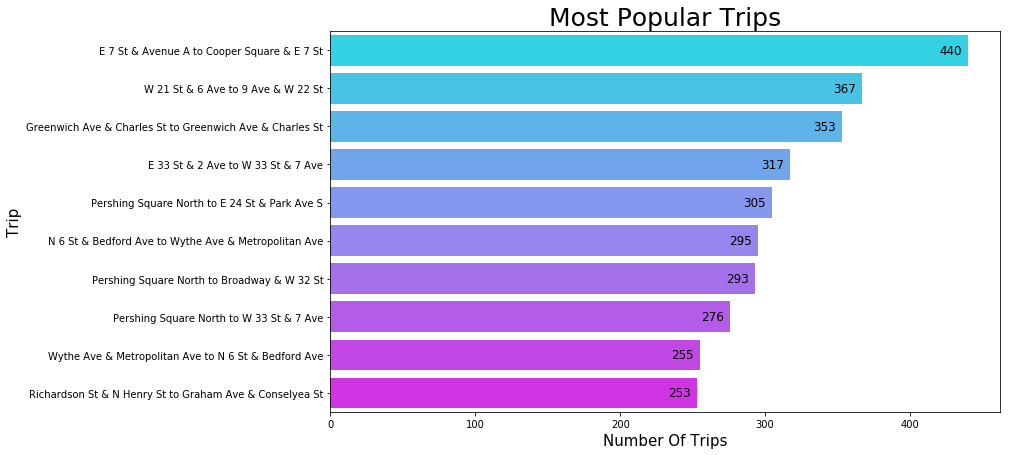

In [46]:
# plot most popular trips 
ax = plt.subplots(figsize = (12, 7))
ax = sns.barplot('NumberOfTrips', 'Trip', data = trips_df, palette = 'cool')
ax.set_title('Most Popular Trips', fontsize = 25)
ax.set_ylabel("Trip", fontsize = 15)
ax.set_xlabel("Number Of Trips", fontsize = 15)
for index, row in trips_df.iterrows(): 
    ax.text(row.NumberOfTrips - 20, index, row.NumberOfTrips, 
             color='black', fontsize = 12, va = 'center')

### Q4: Which bike is the busiest? By number of times used? By minutes used?
We use groupby on the bike id to find the the busiest bikes by number of times used. 

To find the busiest bikes by number of minutes used, we also use groupby on bike id, but get the sum of the 'Minutes' column. 

In [47]:
# find busiest bikes by number of times used
bikes_df = pd.DataFrame()
bikes_df['Times'] = df.groupby(['BikeID']).size()
bikes_df = bikes_df.reset_index()
bikes_df = bikes_df.sort_values('Times', ascending = False) 
bikes_df.BikeID = bikes_df.BikeID.astype('str') 
bikes_df.BikeID = 'Bike ' + bikes_df.BikeID
bikes_df = bikes_df.head(10)
bikes_df = bikes_df.reset_index()

# find busiest bikes by number of minutes used
bikes_min_df = pd.DataFrame()
bikes_min_df['MinutesTotal'] = df.groupby(['BikeID']).Minutes.sum()
bikes_min_df = bikes_min_df.reset_index()
bikes_min_df = bikes_min_df.sort_values('MinutesTotal', ascending = False) 
bikes_min_df.BikeID = bikes_min_df.BikeID.astype('str') 
bikes_min_df.BikeID = 'Bike ' + bikes_min_df.BikeID
bikes_min_df = bikes_min_df.head(10)
bikes_min_df = bikes_min_df.reset_index()

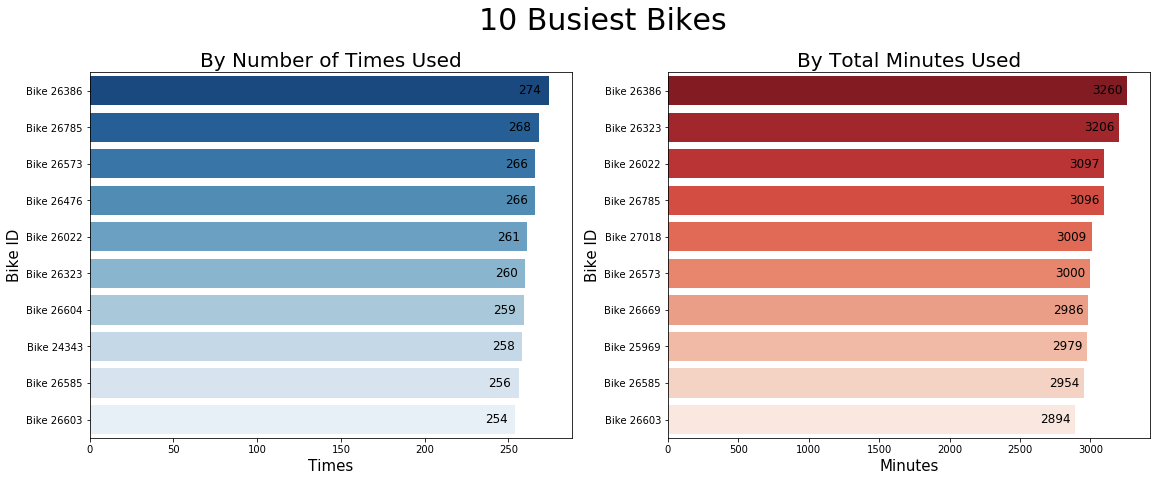

In [48]:
f, axes = plt.subplots(1, 2, figsize = (19, 7))
f.suptitle('10 Busiest Bikes', size = 30)
f.subplots_adjust(top = 0.85)
# plot busiest bikes by number of times used 
ax1 = sns.barplot('Times', 'BikeID', data = bikes_df, ax = axes[0], palette = 'Blues_r')
ax1.set_title('By Number of Times Used', fontsize = 20)
ax1.set_ylabel("Bike ID", fontsize = 15)
ax1.set_xlabel("Times", fontsize = 15)
for index, row in bikes_df.iterrows(): 
    ax1.text(row.Times - 18, index, row.Times, 
             color='black', fontsize = 12, va = 'center')

# plot busiest bikes by number of times used 
ax2 = sns.barplot('MinutesTotal', 'BikeID', data = bikes_min_df, ax = axes[1], palette = 'Reds_r')
ax2.set_title('By Total Minutes Used', fontsize = 20)
ax2.set_ylabel("Bike ID", fontsize = 15)
ax2.set_xlabel("Minutes", fontsize = 15)
for index, row in bikes_min_df.iterrows(): 
    ax2.text(row.MinutesTotal - 250, index, row.MinutesTotal, 
             color='black', fontsize = 12, va = 'center')

## Q5: How is the performance of users by age and gender based on average speed and distance?

For birthyear, we will drop anyone born prior to 1948, as they are likely false inputs. Some senior citizens above 70 can still ride a bike, but that's highly unlikely. Missing birthyears will be replaced with the median birthyear of a group based on gender and start station, as people with same age tend to live in the same neighborhood. 

For gender, we will only compare between male and female. Unknown gender is ignored.

As we don't have the GPS data from each user, we will use the Vincenty formula to calculate the distance between two stations using their latitudes and longtitudes. 

Speed is easily calculated using distance and trip duration. 

In [49]:
# drop people who is older than 70
df = df.drop(df[df.BirthYear < 1948].index)
df['StartCoordinates'] = list(zip(df.StartStationLatitude, df.StartStationLongitude))
df['EndCoordinates'] = list(zip(df.EndStationLatitude, df.EndStationLongitude))

In [50]:
# calculate distance using Vincenty 
from geopy.distance import VincentyDistance
def distancer(row):
    return VincentyDistance(row.StartCoordinates, row.EndCoordinates).kilometers

df['Distance'] = df.apply(distancer, axis=1)

In [51]:
# replace missing birth year by median based on speed and gender 
df.BirthYear = df.groupby(['Gender', 'StartStationID']).BirthYear.transform(lambda x: x.fillna(x.median()))

In [52]:
# drop the remaining null from birth year 
df = df.dropna(subset = ['BirthYear'])

In [53]:
# calculate age 
df['Age'] = 2018 - df.BirthYear
df.Age = df.Age.astype(int)

# drop round trips
df = df.drop(df[df.Distance == 0].index)

# calculate speed in km/h 
df['Speed'] = round(df.Distance/(df.Minutes/60), 2)

In [54]:
round(df.describe(),2)

,TripDuration,StartStationLatitude,StartStationLongitude,EndStationLatitude,EndStationLongitude,BirthYear,Minutes,Distance,Age,Speed
count,702833.00,702833.00,702833.00,702833.00,702833.00,702833.00,702833.00,702833.00,702833.00,702833.00
mean,666.61,40.74,-73.99,40.74,-73.99,1977.44,11.11,1.68,40.56,9.68
std,505.58,0.03,0.02,0.03,0.02,11.41,8.43,1.26,11.41,2.84
min,61.00,40.65,-74.02,40.65,-74.03,1948.00,1.00,0.04,18.00,0.02
25%,329.00,40.72,-74.00,40.72,-74.00,1969.00,5.00,0.84,31.00,7.97
50%,521.00,40.74,-73.99,40.74,-73.99,1980.00,9.00,1.33,38.00,9.64
75%,844.00,40.76,-73.98,40.75,-73.98,1987.00,14.00,2.11,49.00,11.41
max,7228.00,40.80,-73.93,40.80,-73.93,2000.00,120.00,14.45,70.00,30.59


In [60]:
# get performance by speed
# sns.set_style('darkgrid')
df_speed = df.drop(df[df.Gender == 0].index) 
df_speed = df_speed.groupby(['Age', 'Gender']).Speed.mean()
df_speed = df_speed.reset_index()
df_speed.Gender = df_speed.Gender.astype(int)

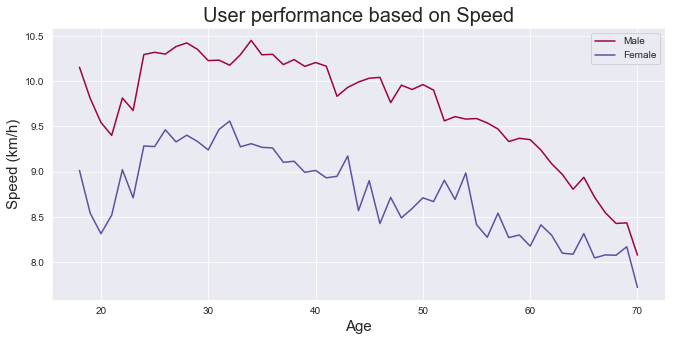

In [70]:
# get performance by speed 
ax = plt.subplots(figsize = (11, 5))
ax = sns.lineplot(x="Age", y="Speed", hue = 'Gender', data=df_speed, palette = 'Spectral') 
ax.set_title('User performance based on Speed', size = 20)
ax.set_xlabel('Age', size = 15)
ax.set_ylabel('Speed (km/h)', size = 15)
ax.legend(['Male', 'Female'])
plt.show()

In [62]:
# get performance by distance
df_dist = df.drop(df[df.Gender == 0].index) 
df_dist = df_dist.groupby(['Age', 'Gender']).Distance.mean()
df_dist = df_dist.reset_index()
df_dist.Gender = df_dist.Gender.astype(int)

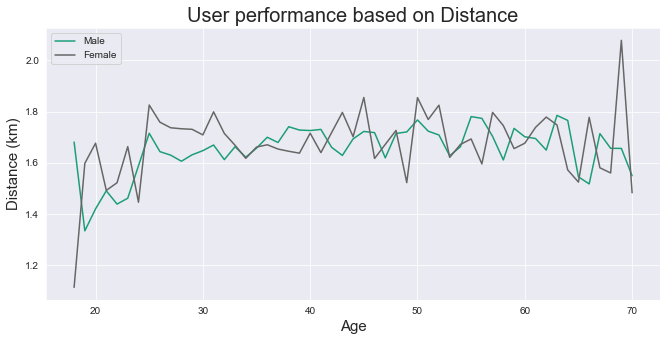

In [68]:
# plot performance by distance
ax = plt.subplots(figsize = (11, 5))
ax = sns.lineplot(x="Age", y="Distance", hue = 'Gender', data=df_dist, palette = 'Dark2') 
ax.set_title('User performance based on Distance', size = 20)
ax.set_xlabel('Age', size = 15)
ax.set_ylabel('Distance (km)', size = 15)
ax.legend(['Male', 'Female'])
plt.show()